In [1]:
import pandas as pd
import re
import sentencepiece as spm

from utils.processing_utils import read_gffs
from utils.tokenizer_utils import train_sentencepiece_tokenizer, compression_ratio

In [2]:
gff_file_path = "ncbi/fungi/GCF_000146045/GCF_000146045.2_R64_genomic.gff"
genome_file_path = "ncbi/fungi/GCF_000146045/GCF_000146045.2_R64_genomic.fna"
output_file_path = "ncbi/fungi/GCF_000146045/joined_cds_sequences.fasta"

cdss = read_gffs(gff_file_path, genome_file_path, output_file_path)
cdss = [str(c.seq).upper() for c in cdss]

cds_file = "ncbi/fungi/GCF_000146045/joined_cds_sequences.txt"
with open(cds_file,'w') as f:
    f.write('\n'.join(cdss))
    

In [ ]:
train_sentencepiece_tokenizer(cds_file, 
                              'ncbi/fungi/GCF_000146045/tokenizer', 
                              10000)

In [ ]:
tokenizer = spm.SentencePieceProcessor(model_file='ncbi/fungi/GCF_000146045/tokenizer.model')

toks = []
for t in tokenizer.encode(cdss):
    toks+=t

In [38]:

    
    
vocab = pd.read_csv('ncbi/fungi/GCF_000146045/tokenizer.vocab',sep='\t',header=None)
dfv = vocab
vocab = vocab[0].tolist()
vocab = [re.sub('[^ACGT]','',v) for v in vocab]


#compression_ratio(''.join(cdss),toks,vocab)

In [14]:
import Bio

str(Bio.Seq.Seq(cdss[4]).translate())

'MAGEAVSEHTPDSQEVTVTSVVCCLDSVVEIGHHVVYSVVTPLIVAVLIDTMAGEAVLEHTSDSQEEIVTTVVCSVVPLVCFVVSVVCFVISVVEIGHHVVYSVVAPLTVTVAVETIAEEMDSVHT*'

In [ ]:
prots = [str(Bio.Seq.Seq(c).translate()) for c in cdss]

prot_file = "ncbi/fungi/GCF_000146045/joined_protein_sequences.txt"
with open(prot_file,'w') as f:
    f.write('\n'.join(prots))
    
train_sentencepiece_tokenizer(prot_file, 
                              'ncbi/fungi/GCF_000146045/protein_tokenizer', 
                              10000)

In [48]:
tokenizer = spm.SentencePieceProcessor(model_file='ncbi/fungi/GCF_000146045/protein_tokenizer.model')

toks = []
for t in tokenizer.encode(prots):
    toks+=t
    
    
vocab = pd.read_csv('ncbi/fungi/GCF_000146045/protein_tokenizer.vocab',sep='\t',header=None)
vocab = vocab[0].tolist()
vocab = [v for v in vocab if type(v)==str]
#vocab = [re.sub('[^ACCT]','',v) for v in vocab]

        
def compression_ratio2(genome,tokens,vocab):
    genome_len = len(genome)
    stokens=set(tokens)
    vocab_len = sum([len(v)+1 for e,v in enumerate(vocab) if e in stokens])-1
    sequence_len = len(' '.join([str(tok2up[i]) for i in tokens]))
    sequence_len = len(' '.join([str(i) for i in tokens]))
    sequence_len = len(tokens)
    return vocab_len,sequence_len,genome_len,\
    (vocab_len+sequence_len)/genome_len

compression_ratio2(''.join(prots),toks,vocab)

(47226, 1121088, 2941688, 0.3971576863351926)

In [45]:
[(tok2up[t],t) for t in toks[:10]]

[(5238, 5898),
 (5465, 6202),
 (62, 71),
 (2576, 1977),
 (7136, 8033),
 (5466, 6199),
 (6366, 7226),
 (162, 164),
 (2844, 3049),
 (7590, 8597)]

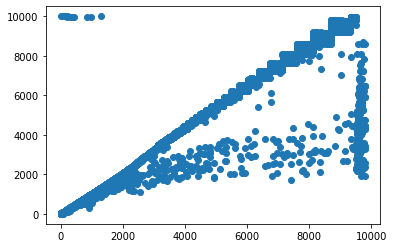

In [39]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
tokcounts = [t for t,_ in Counter(toks).most_common()]
tok2up = {t:e for e,t in enumerate(tokcounts)}
plt.scatter(np.arange(0,len(tokcounts),1),tokcounts)

In [60]:
genome=''.join(cdss)

import lzma

compressed_genome = lzma.compress(bytes(genome,'utf-8'))

In [62]:
len(compressed_genome)/len(genome)

0.2440353973636905

In [74]:
def wrapup(genome):
    code = [('A','00'), 
     ('C','01'),
     ('G','10'),
     ('T','11')]
    for c,d in code:
        genome = genome.replace(c,d)
    encoded_genome =  [chr(int(genome[k:k+8],2)) 
                       for k in np.arange(0,len(genome),8)]
    return ''.join(encoded_genome)
    int('11011000',2)
    chr(int('11011000',2))
    
encoded_genome = wrapup(genome)

compressed_encoded_genome = lzma.compress(bytes(encoded_genome,'utf-8'))

In [76]:
len(compressed_encoded_genome)/len(encoded_genome)


0.9635175450285687

In [ ]:
from utils.gene_utils import revcomp

rev_cdss = [revcomp(c) for c in cdss]

rev_cds_file = "ncbi/fungi/GCF_000146045/joined_rev_cds_sequences.txt"
with open(rev_cds_file,'w') as f:
    f.write('\n'.join(rev_cdss))
    
train_sentencepiece_tokenizer(rev_cds_file, 
                              'ncbi/fungi/GCF_000146045/rev_tokenizer', 
                              10000)


In [46]:

vocab2 = pd.read_csv('ncbi/fungi/GCF_000146045/rev_tokenizer.vocab',sep='\t',header=None)
vocab2 = vocab2[0].tolist()
vocab2 = [v for v in vocab2 if type(v)==str]
vocab2 = [re.sub('[^ACGT]','',v) for v in vocab2]


slope 0.8838515818862354
intercept -0.9262641649043051
r_value 0.8723638806346415
p_value 0.0
std_err 0.006342637352866696


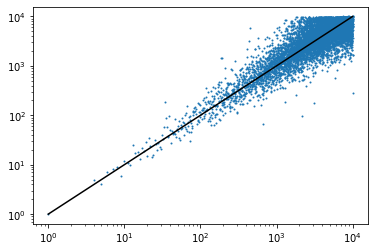

In [47]:
from scipy import stats
V = list(set(vocab)&set(vocab2))
V1 = [vocab.index(v)+1 for v in V]
V2 = [vocab2.index(v)+1 for v in V]
slope, intercept, r_value, p_value, std_err = stats.linregress(
                            -np.log(V1),-np.log(V2))
ns = 'slope, intercept, r_value, p_value, std_err'.split(', ')
for n,x in zip(ns, [slope, intercept, r_value, p_value, std_err]):
    print(n,x)
    
plt.scatter(V1,V2,s=1)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10**4],[1,10**4],c='black')

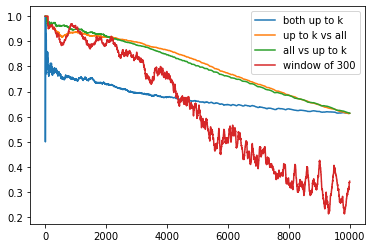

In [48]:
def ov(l1,l2):
    s1, s2 = set(l1),set(l2)
    return len(s1&s2)/min(len(s1),len(s2))

plt.plot([ov(vocab[:k],vocab2[:k]) 
          for k in range(1,len(vocab))],label='both up to k')
plt.plot([ov(vocab[:k],vocab2) 
          for k in range(1,len(vocab))],label='up to k vs all')
plt.plot([ov(vocab,vocab2[:k]) 
          for k in range(1,len(vocab))],label='all vs up to k')
plt.plot([ov(vocab[max(0,k-300):k],vocab2) 
          for k in range(1,len(vocab))],label='window of 300')
plt.legend()
plt.show()

In [51]:
ov(vocab,vocab2)

0.6138673643956929

In [2]:


gff_file_path = "ncbi/animals/GCF_019923935/GCF_019923935.1_NDDB_SH_1_genomic.gff"
genome_file_path = "ncbi/animals/GCF_019923935/GCF_019923935.1_NDDB_SH_1_genomic.fna"
output_file_path = "ncbi/animals/GCF_019923935/joined_cds_sequences.fasta"

cdss = read_gffs(gff_file_path, genome_file_path, output_file_path)
cdss = [str(c.seq).upper() for c in cdss]



In [6]:
sum([len(i) for i in cdss[:500]]),len(cdss)

(1141252, 64670)

In [ ]:
cds_file = "ncbi/animals/GCF_019923935/joined_cds_sequences.txt"
with open(cds_file,'w') as f:
    f.write('\n'.join(cdss[:500]))
    
    
train_sentencepiece_tokenizer(cds_file, 
                              'ncbi/animals/GCF_019923935/tokenizer', 
                              10000)

vocab3 = pd.read_csv('ncbi/animals/GCF_019923935/tokenizer.vocab',sep='\t',header=None)
vocab3 = vocab3[0].tolist()
vocab3 = [v for v in vocab3 if type(v)==str]
vocab3 = [re.sub('[^ACGT]','',v) for v in vocab3]

slope 0.71173273417192
intercept -2.2080593578923313
r_value 0.7005960025971744
p_value 0.0
std_err 0.014366449808432283


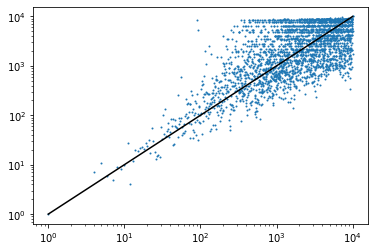

In [40]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

V = list(set(vocab)&set(vocab3))
V1 = [vocab.index(v)+1 for v in V]
V2 = [vocab3.index(v)+1 for v in V]
slope, intercept, r_value, p_value, std_err = stats.linregress(
                            -np.log(V1),-np.log(V2))
ns = 'slope, intercept, r_value, p_value, std_err'.split(', ')
for n,x in zip(ns, [slope, intercept, r_value, p_value, std_err]):
    print(n,x)
    
plt.scatter(V1,V2,s=1)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10**4],[1,10**4],c='black')

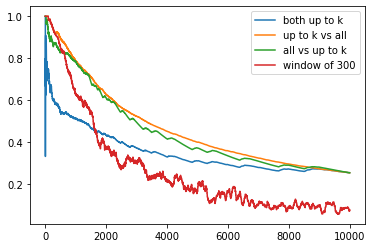

0.2556692755368252

In [41]:
def ov(l1,l2):
    s1, s2 = set(l1),set(l2)
    return len(s1&s2)/min(len(s1),len(s2))

plt.plot([ov(vocab[:k],vocab3[:k]) 
          for k in range(1,len(vocab))],label='both up to k')
plt.plot([ov(vocab[:k],vocab3) 
          for k in range(1,len(vocab))],label='up to k vs all')
plt.plot([ov(vocab,vocab3[:k]) 
          for k in range(1,len(vocab))],label='all vs up to k')
plt.plot([ov(vocab[max(0,k-300):k],vocab3) 
          for k in range(1,len(vocab))],label='window of 300')
plt.legend()
plt.show()
ov(vocab,vocab3)

In [21]:
''.join(np.random.choice(['A','C','G','T'],10))

'CGAGCACCTA'

In [ ]:
cds_file = "ncbi/random/joined_cds_sequences.txt"
rand_cdss = [''.join(np.random.choice(['A','C','G','T'],len(c)))
             for c in cdss[:500]]
with open(cds_file,'w') as f:
    f.write('\n'.join(rand_cdss))
    
    
train_sentencepiece_tokenizer(cds_file, 
                              'ncbi/random/tokenizer', 
                              10000)

vocab4 = pd.read_csv('ncbi/random/tokenizer.vocab',sep='\t',header=None)
vocab4 = vocab4[0].tolist()
vocab4 = [v for v in vocab4 if type(v)==str]
vocab4 = [re.sub('[^ACGT]','',v) for v in vocab4]

slope 0.7680949560351209
intercept -1.869068765439578
r_value 0.7735989071528239
p_value 0.0
std_err 0.013447549467287063


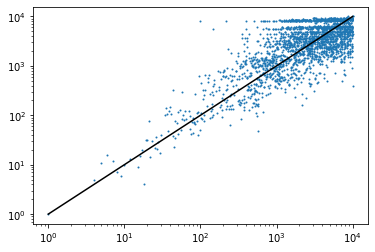

In [50]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

V = list(set(vocab)&set(vocab4))
V1 = [vocab.index(v)+1 for v in V]
V2 = [vocab4.index(v)+1 for v in V]
slope, intercept, r_value, p_value, std_err = stats.linregress(
                            -np.log(V1),-np.log(V2))
ns = 'slope, intercept, r_value, p_value, std_err'.split(', ')
for n,x in zip(ns, [slope, intercept, r_value, p_value, std_err]):
    print(n,x)
    
plt.scatter(V1,V2,s=1)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10**4],[1,10**4],c='black')

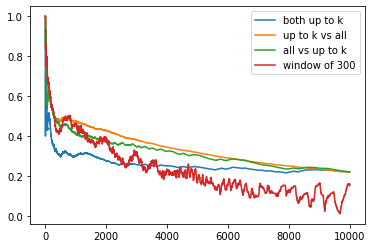

0.22035602936739415

In [44]:
def ov(l1,l2):
    s1, s2 = set(l1),set(l2)
    return len(s1&s2)/min(len(s1),len(s2))

plt.plot([ov(vocab[:k],vocab4[:k]) 
          for k in range(1,len(vocab))],label='both up to k')
plt.plot([ov(vocab[:k],vocab4) 
          for k in range(1,len(vocab))],label='up to k vs all')
plt.plot([ov(vocab,vocab4[:k]) 
          for k in range(1,len(vocab))],label='all vs up to k')
plt.plot([ov(vocab[max(0,k-300):k],vocab4) 
          for k in range(1,len(vocab))],label='window of 300')
plt.legend()
plt.show()
ov(vocab,vocab4)

In [45]:
from collections import Counter
Counter([t[-1] for t in vocab if len(t)>0])

Counter({'A': 456, 'T': 665, 'G': 4400, 'C': 4475})